<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/stock-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series forecasting: Apple stock prediction


In [38]:
!pip install yfinance --quiet

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
# getting data from Yahoo Finance
stock_name = 'AAPL'
data = yf.download(stock_name, start="2010-01-01", end="2025-04-01")

[*********************100%***********************]  1 of 1 completed


In [40]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455076,6.391278,6.422876,493729600
2010-01-05,6.451467,6.487880,6.417460,6.458087,601904800
2010-01-06,6.348844,6.477043,6.342223,6.451463,552160000
2010-01-07,6.337110,6.379844,6.291067,6.372320,477131200
2010-01-08,6.379242,6.379844,6.291369,6.328685,447610800


In [41]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-03-25,223.750000,224.100006,220.080002,220.770004,34493600
2025-03-26,221.529999,225.020004,220.470001,223.509995,34466100
2025-03-27,223.850006,224.990005,220.559998,221.389999,37094800
2025-03-28,217.899994,223.809998,217.679993,221.669998,39818600
2025-03-31,222.130005,225.619995,216.229996,217.009995,65299300


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-01-04 to 2025-03-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3834 non-null   float64
 1   (High, AAPL)    3834 non-null   float64
 2   (Low, AAPL)     3834 non-null   float64
 3   (Open, AAPL)    3834 non-null   float64
 4   (Volume, AAPL)  3834 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 179.7 KB


In [43]:
data['close price']=data['Close']
data.index=pd.to_datetime(data.index)


In [44]:
data.drop(columns=['Open','High','Close','Low','Volume'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-01-04 to 2025-03-31
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (close price, )  3834 non-null   float64
dtypes: float64(1)
memory usage: 59.9 KB


In [45]:
data.head()

Price,close price
Ticker,
Date,
2010-01-04,6.440331
2010-01-05,6.451467
2010-01-06,6.348844
2010-01-07,6.337110
2010-01-08,6.379242


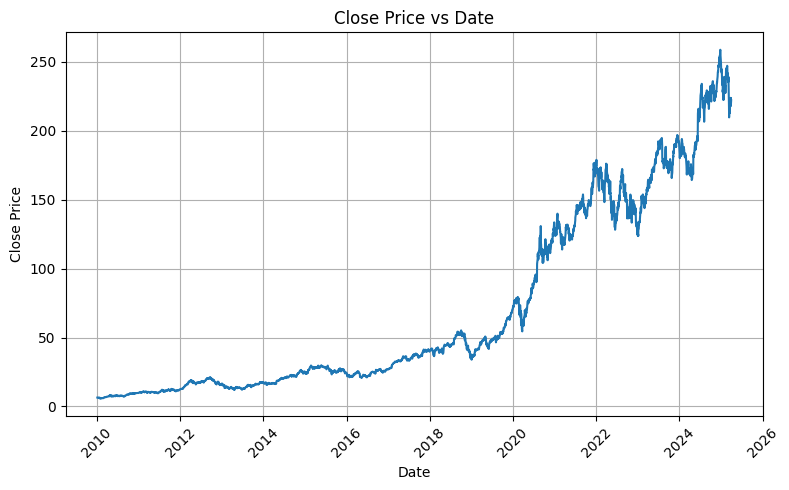

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(data.index, data['close price'])
plt.title('Close Price vs Date')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# facebook Prophet model

In [ ]:
!pip install prophet --quiet

In [ ]:
from prophet import Prophet
Prophet.set_backend("cmdstanpy")

from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

prophet_data=data.reset_index()
prophet_data=prophet_data.rename(columns={'Date':'ds','close price':'y'})
prophet_data.head()

In [ ]:
# 2. Train-Validation-Test Split
train_size = int(0.7 * len(prophet_data))  # 70% train
val_size = int(0.15 * len(prophet_data))   # 15% validation
train_df = prophet_data[:train_size]
val_df = prophet_data[train_size:train_size+val_size]
test_df = prophet_data[train_size+val_size:]

print(f'Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}')


In [ ]:
params_grid = {
    'seasonality_mode': ('multiplicative', 'additive'),
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'n_changepoints': [10, 20, 50]
}

grid = list(ParameterGrid(params_grid))
print(f'Total combinations: {len(grid)}')

# --- Cross-validation (manual) for hyperparameter tuning ---
best_params = None
best_val_mae = float('inf')

for params in grid:
    try:
        # Define model with current params
        model = Prophet(
            seasonality_mode=params['seasonality_mode'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            n_changepoints=params['n_changepoints']
        )

        # Fit on training data
        model.fit(train_df)

        # Make future dataframe covering validation set
        future = val_df[['ds']].copy()
        forecast = model.predict(future)

        # Make sure 'yhat' is in forecast columns
        if 'yhat' not in forecast.columns:
            print(f"⚠️ Skipping params {params} because 'yhat' missing in forecast.")
            continue

        # Evaluation on validation set
        val_pred = forecast['yhat'].values
        val_true = val_df['y'].values

        val_mae = mean_absolute_error(val_true, val_pred)
        val_rmse = mean_squared_error(val_true, val_pred, squared=False)

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params = params

    except Exception as e:
        print(f"⚠️ Skipping params {params} due to error: {e}")
        continue




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Total combinations: 72


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/gacu9bu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/4qriopnh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70398', 'data', 'file=/tmp/tmp4piqu2qx/gacu9bu3.json', 'init=/tmp/tmp4piqu2qx/4qriopnh.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_modelw8spq29y/prophet_model-20250428155539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/ugjn41x7.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/1unq1x3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19069', 'data', 'file=/tmp/tmp4piqu2qx/ugjn41x7.json', 'init=/tmp/tmp4piqu2qx/1unq1x3k.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model9vgrcdix/prophet_model-20250428155540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/xkf14n5e.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/wuai_lhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8260', 'data', 'file=/tmp/tmp4piqu2qx/xkf14n5e.json', 'init=/tmp/tmp4piqu2qx/wuai_lhr.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model31jm50on/prophet_model-20250428155542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/eebc20kh.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/9526rjwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=398', 'data', 'file=/tmp/tmp4piqu2qx/eebc20kh.json', 'init=/tmp/tmp4piqu2qx/9526rjwe.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model9ry3ntnq/prophet_model-20250428155543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/_c5ohzhm.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/t1r3xr4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60556', 'data', 'file=/tmp/tmp4piqu2qx/_c5ohzhm.json', 'init=/tmp/tmp4piqu2qx/t1r3xr4f.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_modela1aa6zw8/prophet_model-20250428155545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:55:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
15:55:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/lpvfgdof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/pj8uzaoh.json
DE

⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'} due to error: 'trend'


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94790', 'data', 'file=/tmp/tmp4piqu2qx/9xghp4h0.json', 'init=/tmp/tmp4piqu2qx/wp34czp4.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model6afpltay/prophet_model-20250428155620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
15:56:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/_yu8r748.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/uww6a9dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanp

⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'n_changepoints': 50, 'seasonality_mode': 'additive'} due to error: 'trend'


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67853', 'data', 'file=/tmp/tmp4piqu2qx/kuiedhdv.json', 'init=/tmp/tmp4piqu2qx/mf72p811.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_modelii_647mw/prophet_model-20250428155659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/ttup70sp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/d_8vzpfe.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative'} due to error: 'trend'


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24583', 'data', 'file=/tmp/tmp4piqu2qx/ttup70sp.json', 'init=/tmp/tmp4piqu2qx/d_8vzpfe.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_modelyy_bd9a4/prophet_model-20250428155700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/5ixkny9q.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/3c10gewr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89453', 'data', 'file=/tmp/tmp4piqu2qx/5ixkny9q.json', 'init=/tmp/tmp4piqu2qx/3c10gewr.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model053blly5/prophet_model-20250428155700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/b6x99cmi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/7z2wzg41.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative'} due to error: 'trend'


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13310', 'data', 'file=/tmp/tmp4piqu2qx/b6x99cmi.json', 'init=/tmp/tmp4piqu2qx/7z2wzg41.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_model0k37785h/prophet_model-20250428155701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/uk0fsv0t.json


⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/kcw0zqvj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74537', 'data', 'file=/tmp/tmp4piqu2qx/uk0fsv0t.json', 'init=/tmp/tmp4piqu2qx/kcw0zqvj.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_modelwf5yz9cr/prophet_model-20250428155702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
15:57:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/m_8d0bvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/_ndnpuei.json
DE

⚠️ Skipping params {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative'} due to error: 'trend'


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/seu2itqu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54835', 'data', 'file=/tmp/tmp4piqu2qx/birgwrth.json', 'init=/tmp/tmp4piqu2qx/seu2itqu.json', 'output', 'file=/tmp/tmp4piqu2qx/prophet_modelpg4qoncy/prophet_model-20250428155727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
15:57:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/c0uqutd4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4piqu2qx/bmi6k3_l.json
DE

In [ ]:
print("\nBest Hyperparameters:")
print(best_params)
print(f'Best Validation MAE: {best_val_mae:.4f}')

In [ ]:
# --- Check for Overfitting ---
# Train error
best_model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    n_changepoints=best_params['n_changepoints']
)

best_model.fit(train_df)

# Predict on training set
train_future = train_df[['ds']]
train_forecast = best_model.predict(train_future)

train_mae = mean_absolute_error(train_df['y'], train_forecast['yhat'])
train_rmse = mean_squared_error(train_df['y'], train_forecast['yhat'], squared=False)

print(f"\nTraining MAE: {train_mae:.4f}")
print(f"Validation MAE: {best_val_mae:.4f}")

if abs(train_mae - best_val_mae) > 0.1 * train_mae:
    print("⚠️  Possible overfitting detected (big train vs val error gap).")
else:
    print("✅ No major overfitting detected.")



In [ ]:
# --- Final Testing on unseen data ---
full_df = pd.concat([train_df, val_df])

final_model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    n_changepoints=best_params['n_changepoints']
)

final_model.fit(full_df)

future = test_df[['ds']]
forecast = final_model.predict(future)

test_pred = forecast['yhat'].values
test_true = test_df['y'].values

test_mae = mean_absolute_error(test_true, test_pred)
test_rmse = mean_squared_error(test_true, test_pred, squared=False)

print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# --- Plot forecast vs actual prices on test set ---
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_true, label='Actual')
plt.plot(test_df['ds'], test_pred, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecast vs Actual Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()


# creating lag features to be used for DNN and ensemble methods

In [ ]:
lags = [1, 7, 30, 365]  # Example: 1-day, 2-day, 5-day, 10-day lags

for lag in lags:
    data[f'Close_lag_{lag}'] = data['close price'].shift(lag)

In [ ]:
data = data.dropna()
data.head()

In [ ]:
data.tail()

In [ ]:
data['date_column']=data.index
data['day'] = data['date_column'].dt.day
data['month'] = data['date_column'].dt.month
data['year'] = data['date_column'].dt.year
data['weekday'] = data['date_column'].dt.day_name()  # Gives full weekday name (e.g., "Thursday")
#data.drop(columns=['date_column'],inplace=True)
data.head()

In [ ]:
data.tail()

In [ ]:
#Cyclic Encoding (Best for LSTMs and Time-Series)
#Best for LSTM models, as it captures the cyclic nature of time-based data.
#Transforms features into sine and cosine to preserve periodicity.
# Convert time-based features into cyclic representation
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['year_sin'] = np.sin(2 * np.pi * data['year'] / 365)
data['year_cos'] = np.cos(2 * np.pi * data['year'] / 365)
data.drop(columns=['day','month','year'],inplace=True)
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['close price',	'Close_lag_1',	'Close_lag_7',	'Close_lag_30',	'Close_lag_365',	'day_sin',	'day_cos', 'month_sin', 'month_cos',	'year_sin',	'year_cos', 'weekday']], data['close price'], test_size=0.2, shuffle=False)
print("Training Dates:", len(X_train))
print("Testing Dates:", len(X_test))
X_train.head()

A lag is a time delay or offset in a time series, representing a past value of a variable used to predict its future values.
Example:
If you're forecasting sales, a lag of 1 might mean using last month's sales to predict this month's sales.
Purpose:
Lags help capture the relationships between past and future values of a variable, which can be crucial for accurate forecasting.

ARIMA, SARIMA, and Temporal Fusion Transformer (TFT) Models:

ARIMA (Autoregressive Integrated Moving Average):
A statistical model that uses past values of a time series (autoregressive), differencing to achieve stationarity (integrated), and past forecast errors (moving average) to predict future values.
Strengths: Can handle a wide range of time series patterns, including trends and seasonality.
Limitations: Assumes linear relationships and may struggle with complex patterns.

SARIMA (Seasonal ARIMA):
An extension of ARIMA that incorporates seasonal patterns in the data.
Strengths: Captures both non-seasonal and seasonal patterns in the data.
Limitations: Still assumes linear relationships and may struggle with complex patterns.

Temporal Fusion Transformer (TFT):
A deep learning model that uses self-attention mechanisms to capture complex temporal patterns across multiple time sequences.
Strengths: Can handle complex patterns, multi-horizon forecasting, and interpretability through attention mechanisms.
Limitations: Requires a large amount of data and can be computationally expensive

# LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.fit_transform(
    X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)

X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.transform(
    X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)
X_train = pd.get_dummies(X_train, columns=['weekday'], drop_first=True)  # drop_first to avoid dummy variable trap
X_test = pd.get_dummies(X_test, columns=['weekday'], drop_first=True)

X_train.head()

In [ ]:
X_test.head()

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
X_train.shape[0]

In [ ]:
time_steps = 1
# Calculate how many complete sequences you can create
num_samples = X_train.shape[0] // time_steps
# Reshape the data accordingly
X_train_reshaped = X_train.values[:num_samples * time_steps].reshape((num_samples, time_steps, X_train.shape[1]))
print(X_train_reshaped.shape)

In [ ]:
# Ensure your test data is reshaped similarly to the training data
# Calculate the number of full sequences in the test data
num_samples_test = X_test.shape[0] // time_steps
# Reshape X_test into the same shape as X_train_reshaped
X_test_reshaped = X_test.values[:num_samples_test * time_steps].reshape((num_samples_test, time_steps, X_test.shape[1]))
# Check the new shape of X_test_reshaped
print(X_test_reshaped.shape)

In [ ]:
X_train_reshaped.dtype
# Ensure that your features (X_train_reshaped) are of numeric type
X_train_reshaped = X_train_reshaped.astype('float32')

# Ensure that your target variable (y_train) is of numeric type
y_train = y_train.astype('float32')

# Similarly, apply the same for validation data if needed
X_test_reshaped = X_test_reshaped.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),  # (time_steps, features)
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=500, batch_size=1000, validation_data=(X_test_reshaped, y_test))


In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted prices
plt.figure(figsize=(10,6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Prices")
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Prices")
plt.legend()
plt.title("Stock Price Prediction with LSTM")
plt.show()